In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/mission

/content/drive/MyDrive/Colab Notebooks/mission


# 패키지

In [3]:
import os
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms

# PyTorch Information

In [4]:
is_cuda = torch.cuda.is_available()

print('Torch Version : {}'.format(torch.__version__))
print('CUDA Available : {}'.format(is_cuda))
if is_cuda :
  print('Torch Device : {}'.format(torch.cuda.get_device_name()))

device = 'cuda' if is_cuda else 'cpu'

Torch Version : 1.9.0+cu102
CUDA Available : True
Torch Device : Tesla T4


# 데이터셋 준비

In [5]:
train_df = pd.read_csv('trainLabels_cropped.csv')
train_df = train_df.drop('Unnamed: 0', axis=1)
train_df

,image,level
0,9096_right,0
1,41048_left,0
2,21084_right,0
3,28592_left,0
4,33225_right,2
...,...,...
5013,26272_right,0
5014,35343_right,0
5015,41798_right,0
5016,30846_right,1


In [6]:
train_df.groupby('level').count()

,image
level,
0,3722
1,355
2,740
3,119
4,82


## Dataset Transform

In [7]:
dataset_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## ImageDataset 클래스 선언

In [8]:
class ImageDataset(Dataset) :
  def __init__(self, df, root_dir, transform=None) :
    self.df = df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self) :
    return len(self.df)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.df.iloc[index].image +".jpeg")
    img = Image.open(img_path)
    
    if self.transform :
      img = self.transform(img)
    
    return img, torch.tensor(self.df.iloc[index].level)

## 데이터셋 불러오기

In [9]:
train_dataset = ImageDataset(train_df, 'train', dataset_transform)

### 데이터셋 확인

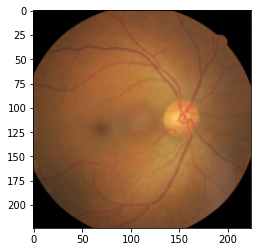

In [10]:
img, label = train_dataset[0]

plt.imshow(img.permute(1,2,0))

# 모델 준비

## 모델 불러오기

In [11]:
model = resnet50(pretrained=True)

for param in model.parameters() :
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


### FC Layer 수정

In [12]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [13]:
model.fc = nn.Linear(2048, 5, bias=True)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 하이퍼 파라미터

In [19]:
n_classes = 5
learning_rate = 0.0001
epochs = 20

## Optimizer 설정

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.CrossEntropyLoss()

# 학습

## DataLoader 설정

In [17]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 학습 진행

In [20]:
loss_hist = []

for epoch in range(epochs) :
  for x_train, y_train in tqdm(train_dataloader) :
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(x_train)
    optimizer.zero_grad()

    loss = loss_criterion(y_pred, y_train)
    loss_hist.append(loss)
    loss.backward()

    optimizer.step()
    
  print('Epoch {}/{} '.format(epoch+1, epochs))
  print('Loss : {}'.format(loss))
  print('\n------------------')

  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 1/20 
Loss : 0.7229569554328918


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 2/20 
Loss : 0.9366400837898254


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 3/20 
Loss : 1.2657171487808228


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 4/20 
Loss : 0.5415191054344177


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 5/20 
Loss : 0.7503871917724609


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 6/20 
Loss : 0.5215638875961304


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 7/20 
Loss : 0.8642046451568604


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 8/20 
Loss : 0.8358040452003479


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 9/20 
Loss : 0.4011525809764862


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 10/20 
Loss : 0.7937770485877991


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 11/20 
Loss : 0.6037190556526184


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 12/20 
Loss : 0.8795295357704163


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 13/20 
Loss : 1.1627291440963745


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 14/20 
Loss : 0.5340934991836548


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 15/20 
Loss : 0.6295689940452576


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 16/20 
Loss : 0.8593544363975525


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 17/20 
Loss : 0.5982277989387512


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 18/20 
Loss : 0.49877503514289856


  0%|          | 0/79 [00:00<?, ?it/s]


------------------
Epoch 19/20 
Loss : 0.5867730379104614


100%|██████████| 79/79 [12:35<00:00,  9.56s/it]


------------------
Epoch 20/20 
Loss : 0.5591064691543579


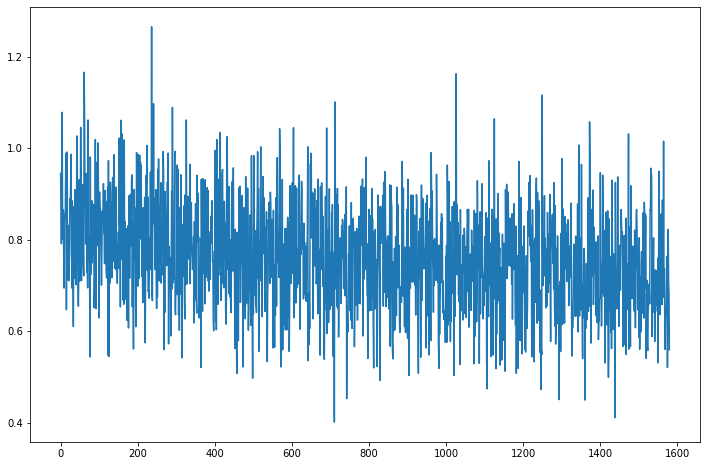

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(loss_hist)
plt.show()

In [23]:
torch.save(model.state_dict(), 'day3mission.pt')